In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import xarray as xr
import os
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy import stats
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
from geocat.comp import eofunc_eofs, eofunc_pcs
from sklearn.cross_decomposition import CCA
import geocat.datafiles as gdf
import geocat.viz as gv
import cdo
import matplotlib.colors as colors
import matplotlib.patches as mpatch
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import tabulate

/home/csys/pevaidea/isibhv/projects/paleo_work/.conda/envs/geocat/lib/python3.10/site-packages/geocat/viz/cmaps.py:9: DeprecationWarning: geocat.viz.cmaps is deprecated, use cmaps instead
  warnings.warn("geocat.viz.cmaps is deprecated, use cmaps instead",


***Data***

Source of the data: https://zenodo.org/records/13861997.

Goosse, H., Dalaiden, Q., Francis, F., Mezzina, B. and Fogt R., A drop in Antarctic sea ice extent at the end of the 1970s, Communication Earth & Environment.

sea ice concentration (sic) 2-m air temperature (t2m)

The reconstructions performed with the 9 ESMs are provided. Each NetCDF file corresponds to one variable. All fields are anomalies relative to the 1981–2010 period.

The code to reproduce the reconstructions is available at https://github.com/dalaiden/DA_offline_PF.

In [3]:
# Load the dataset
fnc = 't2m_ano_annual_recon-goosse-et-al24_UKESM1-0-LL_1958-2023.nc'
dsg = xr.open_dataset(fnc)
print(dsg)

<xarray.Dataset>
Dimensions:  (time: 66, lat: 51, lon: 360)
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 2023-01-01 00:00:00
  * lat      (lat) float64 -40.0 -41.0 -42.0 -43.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    t2m      (time, lat, lon) float32 ...
    t2m_unc  (time, lat, lon) float32 ...
Attributes:
    prior:         UKESM1-0-LL
    history:       Created on Mon Sep 30 15:12:51 2024
    program_used:  Python
    source:        /home/elic/dalaiden/20th_reconstruction_hgs_fogt/shared_da...
    author:        Q. Dalaiden (quentin.dalaiden@uclouvain.be; quentin.dalaid...


/home/csys/pevaidea/isibhv/projects/paleo_work/.conda/envs/geocat/lib/python3.10/site-packages/xarray/backends/plugins.py:98: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())


***EOF on SAT data***

In [4]:
#Select period and region

ystr = 1958
yend = 2023

latS = -90.
latN = -40.
lonW = 0.
lonE = 359.

neof = 8

anm=dsg.t2m
#print(anm)

# put the data in a format required by geocat.eof and which can allow to make easy changes regarding the region/period selected

anmD = anm.sortby("lat", ascending=True)
clat = anmD['lat'].astype(np.float64)
clat = np.sqrt(np.cos(np.deg2rad(clat)))
wanm = anmD 
wanm = anmD* clat
wanm.attrs = anmD.attrs
wanm.attrs['long_name'] = 'Wgt: ' + wanm.attrs['long_name']
#print(wanm)

lon = wanm['lon']
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm=wanm.assign_coords(lon=( (lon + 180) % 360 - 180) )
   wanm = wanm.sortby("lon")
   print(' change longitude ')
         #print(wanm)  
    
xw = wanm.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))
xw_anm = xw.transpose('time', 'lat', 'lon')
    #print(xw_anm)
    
lon = wanm['lon']
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm=wanm.assign_coords(lon=( (lon + 180) % 360 - 180) )
   wanm = wanm.sortby("lon")
   print(' change longitude ')
 
#print(wanm) 

# -- Perfom EOF analysis

eofs_sst = eofunc_eofs(xw_anm.data, neofs=neof, meta=True)
pcs_sst = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)
pcs_norm_sst = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)
sdev_sst=pcs_sst.std(dim='time')
pcs_norm_sst = pcs_sst / pcs_sst.std(dim='time')
pcs_norm_sst['time']=anmD['time']
pcs_sst['time']=anmD['time']
pcs_sst.attrs['varianceFraction'] = eofs_sst.attrs['varianceFraction']
pcs_norm_sst.attrs['varianceFraction'] = eofs_sst.attrs['varianceFraction']
#print(pcs)
evec_sst = xr.DataArray(data=eofs_sst, dims=('eof','lat','lon'),
    coords = {'eof': np.arange(0,neof), 'lat': xw['lat'], 'lon': xw['lon']} )
#print(evec_sst)
eigenvalues_sst = eofs_sst.attrs['varianceFraction']

***Reconstruct the SAT field based on the first 8 EOFs***

In [5]:
#export the PCs in a format usable for CCA

df=pcs_norm_sst.to_dataframe().unstack().transpose() 
df.to_csv('RezEOF.PC.sat.19582023.8pcs.normalized.txt')

In [6]:
import os
import numpy as np
import xarray as xr
import pandas as pd  # For datetime conversion
import netCDF4
import cftime

# Assuming evec_sst (EOFs) and pcs_sst (Principal Components) are obtained from previous steps

# Step 1: Multiply each EOF with its associated PC to reconstruct the initial field
eof_pcs_products = []
for i in range(8):  # Using the first 8 EOFs
    eof_pcs_product = pcs_sst[i, :] * evec_sst.sel(eof=i)
    eof_pcs_products.append(eof_pcs_product)

# Step 2: Sum the products to reconstruct the initial field
reconstructed_field = sum(eof_pcs_products)

# Output file setup
output_file = "SAT_rec8EOF19582023_ok.nc"
ncfile = netCDF4.Dataset(output_file, mode='w', format='NETCDF4')

# Create dimensions
ncfile.createDimension('lat', reconstructed_field.sizes['lat'])
ncfile.createDimension('lon', reconstructed_field.sizes['lon'])
ncfile.createDimension('time', reconstructed_field.sizes['time'])

# Create variables in the NetCDF file
latitudes = ncfile.createVariable('lat', np.float32, ('lat',))
longitudes = ncfile.createVariable('lon', np.float32, ('lon',))
times = ncfile.createVariable('time', np.float64, ('time',))  # Use np.float64 for datetime64 compatibility

# Assign data to variables
latitudes[:] = reconstructed_field['lat'].values
longitudes[:] = reconstructed_field['lon'].values

# Convert time values from cftime to standard datetime
time_values = dsg['time'].values  # Get time values from the dataset

# Convert `cftime.DatetimeNoLeap` to Python datetime
datetime_values = [pd.Timestamp(t.year, t.month, t.day) for t in time_values]

# Assign time data with correct units and values
times.units = 'days since 1950-01-01 00:00:00'
times.calendar = 'gregorian'
times[:] = netCDF4.date2num(datetime_values, units=times.units, calendar=times.calendar)

# sst variable
sst_var = ncfile.createVariable('sst', np.float32, ('time', 'lat', 'lon'))
sst_var[:, :, :] = reconstructed_field.data  # Assuming reconstructed_field is an xarray DataArray with the correct shape

# Close the file
ncfile.close()

print(f"Reconstructed NetCDF file saved: {output_file}")

Reconstructed NetCDF file saved: SAT_rec8EOF19582023_ok.nc


***EOF on Antarctic SIC***

In [7]:
fnc = 'sic_ano_annual_recon-goosse-et-al24_UKESM1-0-LL_1958-2023.nc'
ds1_sic = xr.open_dataset(fnc)
print(ds1_sic)

<xarray.Dataset>
Dimensions:  (time: 66, lat: 51, lon: 360)
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 2023-01-01 00:00:00
  * lat      (lat) float64 -40.0 -41.0 -42.0 -43.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    sic      (time, lat, lon) float32 ...
    sic_unc  (time, lat, lon) float32 ...
Attributes:
    prior:         UKESM1-0-LL
    history:       Created on Mon Sep 30 15:12:51 2024
    program_used:  Python
    source:        /home/elic/dalaiden/20th_reconstruction_hgs_fogt/shared_da...
    author:        Q. Dalaiden (quentin.dalaiden@uclouvain.be; quentin.dalaid...


In [8]:
import xarray as xr
import numpy as np


# Identify the fill value (commonly found in NetCDF files for missing data)
fill_value = 9.969e+36

# Replace fill values with NaN
sic_var = ds1_sic['sic']
sic_var = sic_var.where(sic_var < 1e+36, np.nan)

# Compute and display basic statistics after cleaning
sic_mean = sic_var.mean(dim=['time', 'lat', 'lon'], skipna=True).values
sic_std = sic_var.std(dim=['time', 'lat', 'lon'], skipna=True).values
sic_min = sic_var.min(dim=['time', 'lat', 'lon'], skipna=True).values
sic_max = sic_var.max(dim=['time', 'lat', 'lon'], skipna=True).values
sic_missing = sic_var.isnull().sum().values

# Print diagnostics
print("Dataset Statistics After Cleaning:")
print(f"Mean: {sic_mean}")
print(f"Standard Deviation: {sic_std}")
print(f"Min Value: {sic_min}")
print(f"Max Value: {sic_max}")
print(f"Total Missing Values: {sic_missing}")

# Save the cleaned dataset if needed
ds1_sic['sic'] = sic_var
ds1_sic.to_netcdf("sic_OK_ano_annual_recon-goosse-et-al24_UKESM1-0-LL_1958-2023.nc")
print("Cleaned dataset'")

Dataset Statistics After Cleaning:
Mean: -0.02447550557553768
Standard Deviation: 3.301475763320923
Min Value: -46.631744384765625
Max Value: 50.08803176879883
Total Missing Values: 480414
Cleaned dataset'


In [9]:
fnc = 'sic_OK_ano_annual_recon-goosse-et-al24_UKESM1-0-LL_1958-2023.nc'
ds1_sic = xr.open_dataset(fnc)
print(ds1_sic)

<xarray.Dataset>
Dimensions:  (time: 66, lat: 51, lon: 360)
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 2023-01-01 00:00:00
  * lat      (lat) float64 -40.0 -41.0 -42.0 -43.0 ... -87.0 -88.0 -89.0 -90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    sic      (time, lat, lon) float32 ...
    sic_unc  (time, lat, lon) float32 ...
Attributes:
    prior:         UKESM1-0-LL
    history:       Created on Mon Sep 30 15:12:51 2024
    program_used:  Python
    source:        /home/elic/dalaiden/20th_reconstruction_hgs_fogt/shared_da...
    author:        Q. Dalaiden (quentin.dalaiden@uclouvain.be; quentin.dalaid...


In [10]:
# ----- Period and area setting ------
ystr = 1958
yend = 2023

latS = -90.
latN = -40.
lonW = 0.
lonE = 360.
neof = 8

anm=ds1_sic.sic

# -- EOF --

anmnD = anm.sortby("lat", ascending=True)
clat = anmnD['lat'].astype(np.float64)
clat = np.sqrt(np.cos(np.deg2rad(clat)))
wanm = anmnD 
wanm = anmnD * clat
wanm.attrs = anmnD.attrs
#wanm.attrs['long_name'] = 'Wgt: ' + wanm.attrs['long_name']
#print(wanm)

lon = wanm['lon']
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm=wanm.assign_coords(lon=( (lon + 180) % 360 - 180) )
   wanm = wanm.sortby("lon")
   print(' change lon ')
#print(wanm)

xw = wanm.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))
xw_anm = xw.transpose('time', 'lat', 'lon')
#print(xw_anm)

eofs_sic = eofunc_eofs(xw_anm.data, neofs=neof, meta=True)
pcs_sic = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)
pcs_norm_sic = pcs_sic / pcs_sic.std(dim='time')
pcs_sic['time']=anmnD['time']
pcs_norm_sic['time']=anmnD['time']
pcs_sic.attrs['varianceFraction'] = eofs_sic.attrs['varianceFraction']
pcs_norm_sic.attrs['varianceFraction'] = eofs_sic.attrs['varianceFraction']
#print(pcs_norm_sic)
sdev_pc1=pcs_sic[0].std (dim='time')
#print(sdev_pc1)
evec_sic = xr.DataArray(data=eofs_sic, dims=('eof','lat','lon'),
    coords = {'eof': np.arange(0,neof), 'lat': xw['lat'], 'lon': xw['lon']} )
#print(evec_sic)
eigenvalues_sic = eofs_sic.attrs['varianceFraction']

***Reconstruct the SIC field based on the first 8 EOFs***

In [12]:
#export the PCs in a format usable for CCA

df=pcs_norm_sic.to_dataframe().unstack().transpose() 
df.to_csv('RezEOF.SIC.19582023.8PCs.normalized.VF.txt')

In [13]:
import os
import netCDF4
import numpy as np
import xarray as xr
import pandas as pd
import cftime

# Using evec_sic and pcs_sic from your EOF script
# evec_sic: The EOFs
# pcs_sic: The Principal Components

# Step 1: Multiply each EOF with its associated PC
eof_pcs_products = []
for i in range(8):  # Using the first 8 EOFs
    eof_pcs_products.append(pcs_sic[i, :] * evec_sic[i, :, :])

# Step 2: Sum the products to reconstruct the initial field
reconstructed_field = sum(eof_pcs_products)

# Step 3: Export the reconstructed field to a NetCDF file
output_file = "SIC_rec8EOF195802023.nc"
ncfile = netCDF4.Dataset(output_file, mode='w', format="NETCDF4")

# Use correct dimension names ('lat' and 'lon' instead of 'latitude' and 'longitude')
ncfile.createDimension('lat', len(reconstructed_field['lat']))
ncfile.createDimension('lon', len(reconstructed_field['lon']))
ncfile.createDimension('time', None)

# Create variables in the NetCDF file
latitudes = ncfile.createVariable('lat', np.float32, ('lat',))
longitudes = ncfile.createVariable('lon', np.float32, ('lon',))
times = ncfile.createVariable('time', np.float64, ('time',))  # Use np.float64 for datetime64 compatibility

# Name the variable as 'sic'
sic_var = ncfile.createVariable('sic', np.float32, ('time', 'lat', 'lon'))

# Assign data to variables
latitudes[:] = reconstructed_field['lat'].values
longitudes[:] = reconstructed_field['lon'].values

# Convert time values from cftime to numerical time units
time_values = pcs_sic['time'].values  # Get time values

# Convert `cftime.DatetimeNoLeap` to Python datetime
datetime_values = [pd.Timestamp(t.year, t.month, t.day) for t in time_values]

# Assign time data with correct units and values
times.units = 'days since 1950-01-01 00:00:00'
times.calendar = 'gregorian'
times[:] = netCDF4.date2num(datetime_values, units=times.units, calendar=times.calendar)

# Assign the reconstructed field to 'sic'
sic_var[:, :, :] = reconstructed_field.values

# Close the file
ncfile.close()

print(f"Reconstructed NetCDF file saved: {output_file}")

Reconstructed NetCDF file saved: SIC_rec8EOF195802023.nc


***Perfom CCA on annual SAT-SIC reconstrucded fields***

In [14]:
# open the two datasets, reconstructed based on 10EOFS and their asociated PCs

field1 = 'SAT_rec8EOF19582023_ok.nc'
ds1 = xr.open_dataset(field1)
#print(ds1)

field2 = 'SIC_rec8EOF195802023.nc'
ds2= xr.open_dataset(field2)
#print(ds2)

PCsV1=pd.read_csv('RezEOF.PC.sat.19582023.8pcs.normalized.txt',sep=',')
PCsV1_xr=PCsV1.to_xarray().to_array()
PCsSST=PCsV1[['0','1','2','3','4','5','6','7']]

PCsV2=pd.read_csv('RezEOF.SIC.19582023.8PCs.normalized.VF.txt',sep=',')
PCsV2_xr=PCsV2.to_xarray().to_array()
PCsSIC=PCsV2[['0','1','2','3','4','5','6','7']]
#X2

In [16]:
#Normalize the PCs (if necesary) 
X1_mc = (PCsSST-PCsSST.mean())/(PCsSST.std())
#X1_mc.head()
X2_mc = (PCsSIC-PCsSIC.mean())/(PCsSIC.std())
#X2_mc.head()

In [17]:
#Perform CCA between the 10PCs obtaine trough EOF on SST and SIC detrended annual anomalies

ca = CCA(n_components=8)
ca.fit(X1_mc, X2_mc)
X_c, Y_c = ca.transform(X1_mc, X2_mc)

#export the pairs of maximum corelated PCs obtained from CCA

cc_res = pd.DataFrame({"CCX_1":X_c[:, 0],
                       "CCY_1":Y_c[:, 0],
                       "CCX_2":X_c[:, 1],
                       "CCY_2":Y_c[:, 1],
                       "CCX_3":X_c[:, 2],
                       "CCY_3":Y_c[:, 2],
                       "CCX_4":X_c[:, 3],
                       "CCY_4":Y_c[:, 3],
                        "CCX_5":X_c[:, 4],
                        "CCY_5":Y_c[:, 4],
                        "CCX_6":X_c[:, 5],
                         "CCY_6":Y_c[:, 5],
                         "CCX_7":X_c[:, 6],
                         "CCY_7":Y_c[:, 6],
                         "CCX_8":X_c[:, 7],
                         "CCY_8":Y_c[:, 7],
                       #"Species":df.species.tolist(),
                      })
# cc_res.head()

In [18]:
#plot the corelatio coefficients betweent the PCs
CCAresultPccorr=[]
for p in range (np.shape(X_c)[1]):
        print(np.corrcoef(X_c[:, p], Y_c[:, p]))

[[1.         0.99654134]
 [0.99654134 1.        ]]
[[1.         0.98823553]
 [0.98823553 1.        ]]
[[1.         0.97818171]
 [0.97818171 1.        ]]
[[1.         0.96492312]
 [0.96492312 1.        ]]
[[1.         0.95210619]
 [0.95210619 1.        ]]
[[1.         0.88912733]
 [0.88912733 1.        ]]
[[1.        0.7266688]
 [0.7266688 1.       ]]
[[1.         0.37516113]
 [0.37516113 1.        ]]


Correlation Coefficients for CCA Pairs
| Pair   |   Corr Coef. |
|:-------|-------------:|
| Pair 1 |     0.996541 |
| Pair 2 |     0.988236 |
| Pair 3 |     0.978182 |
| Pair 4 |     0.964923 |
| Pair 5 |     0.952106 |
| Pair 6 |     0.889127 |
| Pair 7 |     0.726669 |
| Pair 8 |     0.375161 |


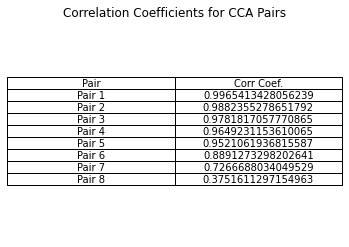

In [19]:
from tabulate import tabulate as tb
import pandas as pd
import matplotlib.pyplot as plt

CCAresultPccorr = []
for p in range(np.shape(X_c)[1]):
    corr = np.corrcoef(X_c[:, p], Y_c[:, p])[0, 1]
    CCAresultPccorr.append(('Pair %d' % (p+1), corr))

# create a table with the results
headers = ['Pair', 'Corr Coef.']
table = tb(CCAresultPccorr, headers=headers, tablefmt='pipe')

# print the table
print('Correlation Coefficients for CCA Pairs')
print(table)

# save the table as an image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')
ax.axis('tight')
table_data = [['Pair', 'Corr Coef.']] + CCAresultPccorr
ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
plt.title('Correlation Coefficients for CCA Pairs')
plt.savefig('correlation_table.jpg', dpi=400)

# save the table as an Excel file
df = pd.DataFrame(CCAresultPccorr, columns=headers)
df.to_excel('correlation_table.xlsx', index=False)


In [20]:
#select the first 10 individual pcs 
rezcca=cc_res.to_xarray()
PC1sst=rezcca['CCX_1']
PC1sic=rezcca['CCY_1']
PC2sst=rezcca['CCX_2']
PC2sic=rezcca['CCY_2']
PC3sst=rezcca['CCX_3']
PC3sic=rezcca['CCY_3']
PC4sst=rezcca['CCX_4']
PC4sic=rezcca['CCY_4']
PC5sst=rezcca['CCX_5']
PC5sic=rezcca['CCY_5']
PC6sst=rezcca['CCX_6']
PC6sic=rezcca['CCY_6']
PC7sst=rezcca['CCX_7']
PC7sic=rezcca['CCY_7']
PC8sst=rezcca['CCX_8']
PC8sic=rezcca['CCY_8']


#reindex the time axis in the PCs

PC1sst= PC1sst.rename({"index": "time"})
PC2sst= PC2sst.rename({"index": "time"})
PC3sst= PC3sst.rename({"index": "time"})
PC4sst= PC4sst.rename({"index": "time"})
PC5sst= PC5sst.rename({"index": "time"})
PC6sst= PC6sst.rename({"index": "time"})
PC7sst= PC7sst.rename({"index": "time"})
PC8sst= PC8sst.rename({"index": "time"})

PC1sic= PC1sic.rename({"index": "time"})
PC2sic= PC2sic.rename({"index": "time"})
PC3sic= PC3sic.rename({"index": "time"})
PC4sic= PC4sic.rename({"index": "time"})
PC5sic= PC5sic.rename({"index": "time"})
PC6sic= PC6sic.rename({"index": "time"})
PC7sic= PC7sic.rename({"index": "time"})
PC8sic= PC8sic.rename({"index": "time"})

PC1sst['time'] = ds1.time
PC2sst['time'] = ds1.time
PC3sst['time'] = ds1.time
PC4sst['time'] = ds1.time
PC5sst['time'] = ds1.time
PC6sst['time'] = ds1.time
PC7sst['time'] = ds1.time
PC8sst['time'] = ds1.time


PC1sic['time'] = ds2.time
PC2sic['time'] = ds2.time
PC3sic['time'] = ds2.time
PC4sic['time'] = ds2.time
PC5sic['time'] = ds2.time
PC6sic['time'] = ds2.time
PC7sic['time'] = ds2.time
PC8sic['time'] = ds2.time


In [21]:
#Obtain the associated spatial structures trough linear regression analisis of reconstructed SST/SIC fields on the CCA time series from each pair

regSST1 = xr.cov(PC1sst.load(), ds1.sst.load(), dim="time")/PC1sst.var(dim='time',skipna=True).values
regSST2 = xr.cov(PC2sst.load(), ds1.sst.load(), dim="time")/PC2sst.var(dim='time',skipna=True).values
regSST3 = xr.cov(PC3sst.load(), ds1.sst.load(), dim="time")/PC3sst.var(dim='time',skipna=True).values
regSST4 = xr.cov(PC4sst.load(), ds1.sst.load(), dim="time")/PC4sst.var(dim='time',skipna=True).values
regSST5 = xr.cov(PC5sst.load(), ds1.sst.load(), dim="time")/PC5sst.var(dim='time',skipna=True).values
regSST6 = xr.cov(PC6sst.load(), ds1.sst.load(), dim="time")/PC6sst.var(dim='time',skipna=True).values
regSST7 = xr.cov(PC7sst.load(), ds1.sst.load(), dim="time")/PC7sst.var(dim='time',skipna=True).values
regSST8 = xr.cov(PC8sst.load(), ds1.sst.load(), dim="time")/PC8sst.var(dim='time',skipna=True).values

regSIC1 = xr.cov(PC1sic.load(), ds2.sic.load(), dim="time")/PC1sic.var(dim='time',skipna=True).values
regSIC2 = xr.cov(PC2sic.load(), ds2.sic.load(), dim="time")/PC2sic.var(dim='time',skipna=True).values
regSIC3 = xr.cov(PC3sic.load(), ds2.sic.load(), dim="time")/PC3sic.var(dim='time',skipna=True).values
regSIC4 = xr.cov(PC4sic.load(), ds2.sic.load(), dim="time")/PC4sic.var(dim='time',skipna=True).values
regSIC5 = xr.cov(PC5sic.load(), ds2.sic.load(), dim="time")/PC5sic.var(dim='time',skipna=True).values
regSIC6 = xr.cov(PC6sic.load(), ds2.sic.load(), dim="time")/PC6sic.var(dim='time',skipna=True).values
regSIC7 = xr.cov(PC7sic.load(), ds2.sic.load(), dim="time")/PC7sic.var(dim='time',skipna=True).values
regSIC8 = xr.cov(PC8sic.load(), ds2.sic.load(), dim="time")/PC8sic.var(dim='time',skipna=True).values


In [22]:
import xarray as xr

# Create a new dataset using the existing DataArrays
regression_ds = xr.Dataset(
    {
        "sic1": regSIC1,
        "sic2": regSIC2,
        "sic3": regSIC3,
    }
)

# Save to a NetCDF file
regression_ds.to_netcdf("SIC_UKESM1-0-LL_CCA123.nc")

In [23]:
# Create a new dataset using the existing DataArrays
regression_ds = xr.Dataset(
    {
        "sic1": regSST1,
        "sic2": regSST2,
        "sic3": regSST3,
    }
)
# Save to a NetCDF file
regression_ds.to_netcdf("SAT_UKESM1-0-LL_CCA123.nc")

In [24]:
# Obtain the procentage of variance explained by each spatial structures (as average of r squared), through corelation analysis between the CCA time series from each pair and the SST/SIC fields, reconstructed based on the first 8 EOFs

cor_SST1 = xr.corr(PC1sst.load(), ds1.sst.load(), dim="time")
r1_squared = cor_SST1*cor_SST1
var_sst1=(r1_squared.mean()*100)
var_sst1_round=var_sst1.round(decimals=1)
print(var_sst1_round)

cor_SST2 = xr.corr(PC2sst.load(), ds1.sst.load(), dim="time")
r2_squared = cor_SST2*cor_SST2
var_sst2=r2_squared.mean()*100
var_sst2_round=var_sst2.round(decimals=1)
print(var_sst2_round)

cor_SST3 = xr.corr(PC3sst.load(), ds1.sst.load(), dim="time")
r3_squared = cor_SST3*cor_SST3
var_sst3=r3_squared.mean()*100
var_sst3_round=var_sst3.round(decimals=1)
print(var_sst3_round)

cor_SST4 = xr.corr(PC4sst.load(), ds1.sst.load(), dim="time")
r4_squared = cor_SST4*cor_SST4
var_sst4=r4_squared.mean()*100
var_sst4_round=var_sst4.round(decimals=1)
print(var_sst4_round)

cor_SST5 = xr.corr(PC5sst.load(), ds1.sst.load(), dim="time")
r5_squared = cor_SST5*cor_SST5
var_sst5=r5_squared.mean()*100
var_sst5_round=var_sst5.round(decimals=1)
print(var_sst5_round)

cor_SST6 = xr.corr(PC6sst.load(), ds1.sst.load(), dim="time")
r6_squared = cor_SST6*cor_SST6
var_sst6=r6_squared.mean()*100
var_sst6_round=var_sst6.round(decimals=1)
print(var_sst6_round)

cor_SST7 = xr.corr(PC7sst.load(), ds1.sst.load(), dim="time")
r7_squared = cor_SST7*cor_SST7
var_sst7=r7_squared.mean()*100
var_sst7_round=var_sst7.round(decimals=1)
print(var_sst7_round)

cor_SST8 = xr.corr(PC8sst.load(), ds1.sst.load(), dim="time")
r8_squared = cor_SST8*cor_SST8
var_sst8=r8_squared.mean()*100
var_sst8_round=var_sst8.round(decimals=1)
print(var_sst8_round)


cor_SIC1 = xr.corr(PC1sic.load(), ds2.sic.load(), dim="time")
r1_squared_sic = cor_SIC1*cor_SIC1
var_sic1=r1_squared_sic.mean()*100
var_sic1_round=var_sic1.round(decimals=1)
print(var_sic1_round)

cor_SIC2 = xr.corr(PC2sic.load(), ds2.sic.load(), dim="time")
r2_squared_sic = cor_SIC2*cor_SIC2
var_sic2=r2_squared_sic.mean()*100
var_sic2_round=var_sic2.round(decimals=1)
print(var_sic2_round)

cor_SIC3 = xr.corr(PC3sic.load(), ds2.sic.load(), dim="time")
r3_squared_sic = cor_SIC3*cor_SIC3
var_sic3=r3_squared_sic.mean()*100
var_sic3_round=var_sic3.round(decimals=2)
print(var_sic3_round)

cor_SIC4 = xr.corr(PC4sic.load(), ds2.sic.load(), dim="time")
r4_squared_sic = cor_SIC4*cor_SIC4
var_sic4=r4_squared_sic.mean()*100
var_sic4_round=var_sic4.round(decimals=2)
print(var_sic4_round)

cor_SIC5 = xr.corr(PC5sic.load(), ds2.sic.load(), dim="time")
r5_squared_sic = cor_SIC5*cor_SIC5
var_sic5=r5_squared_sic.mean()*100
var_sic5_round=var_sic5.round(decimals=2)
print(var_sic5_round)

cor_SIC6 = xr.corr(PC6sic.load(), ds2.sic.load(), dim="time")
r6_squared_sic = cor_SIC6*cor_SIC6
var_sic6=r6_squared_sic.mean()*100
var_sic6_round=var_sic6.round(decimals=2)
print(var_sic6_round)

cor_SIC7 = xr.corr(PC7sic.load(), ds2.sic.load(), dim="time")
r7_squared_sic = cor_SIC7*cor_SIC7
var_sic7=r7_squared_sic.mean()*100
var_sic7_round=var_sic7.round(decimals=2)
print(var_sic7_round)

cor_SIC8 = xr.corr(PC8sic.load(), ds2.sic.load(), dim="time")
r8_squared_sic = cor_SIC8*cor_SIC8
var_sic8=r8_squared_sic.mean()*100
var_sic8_round=var_sic8.round(decimals=2)
print(var_sic8_round)



<xarray.DataArray ()>
array(35.2)
<xarray.DataArray ()>
array(21.6)
<xarray.DataArray ()>
array(6.8)
<xarray.DataArray ()>
array(9.4)
<xarray.DataArray ()>
array(6.5)
<xarray.DataArray ()>
array(8.)
<xarray.DataArray ()>
array(3.7)
<xarray.DataArray ()>
array(8.8)
<xarray.DataArray ()>
array(36.3)
<xarray.DataArray ()>
array(16.)
<xarray.DataArray ()>
array(7.69)
<xarray.DataArray ()>
array(12.41)
<xarray.DataArray ()>
array(8.05)
<xarray.DataArray ()>
array(7.8)
<xarray.DataArray ()>
array(6.35)
<xarray.DataArray ()>
array(5.41)


***PLOT THE THREE PAIRS***

***Pair 1***

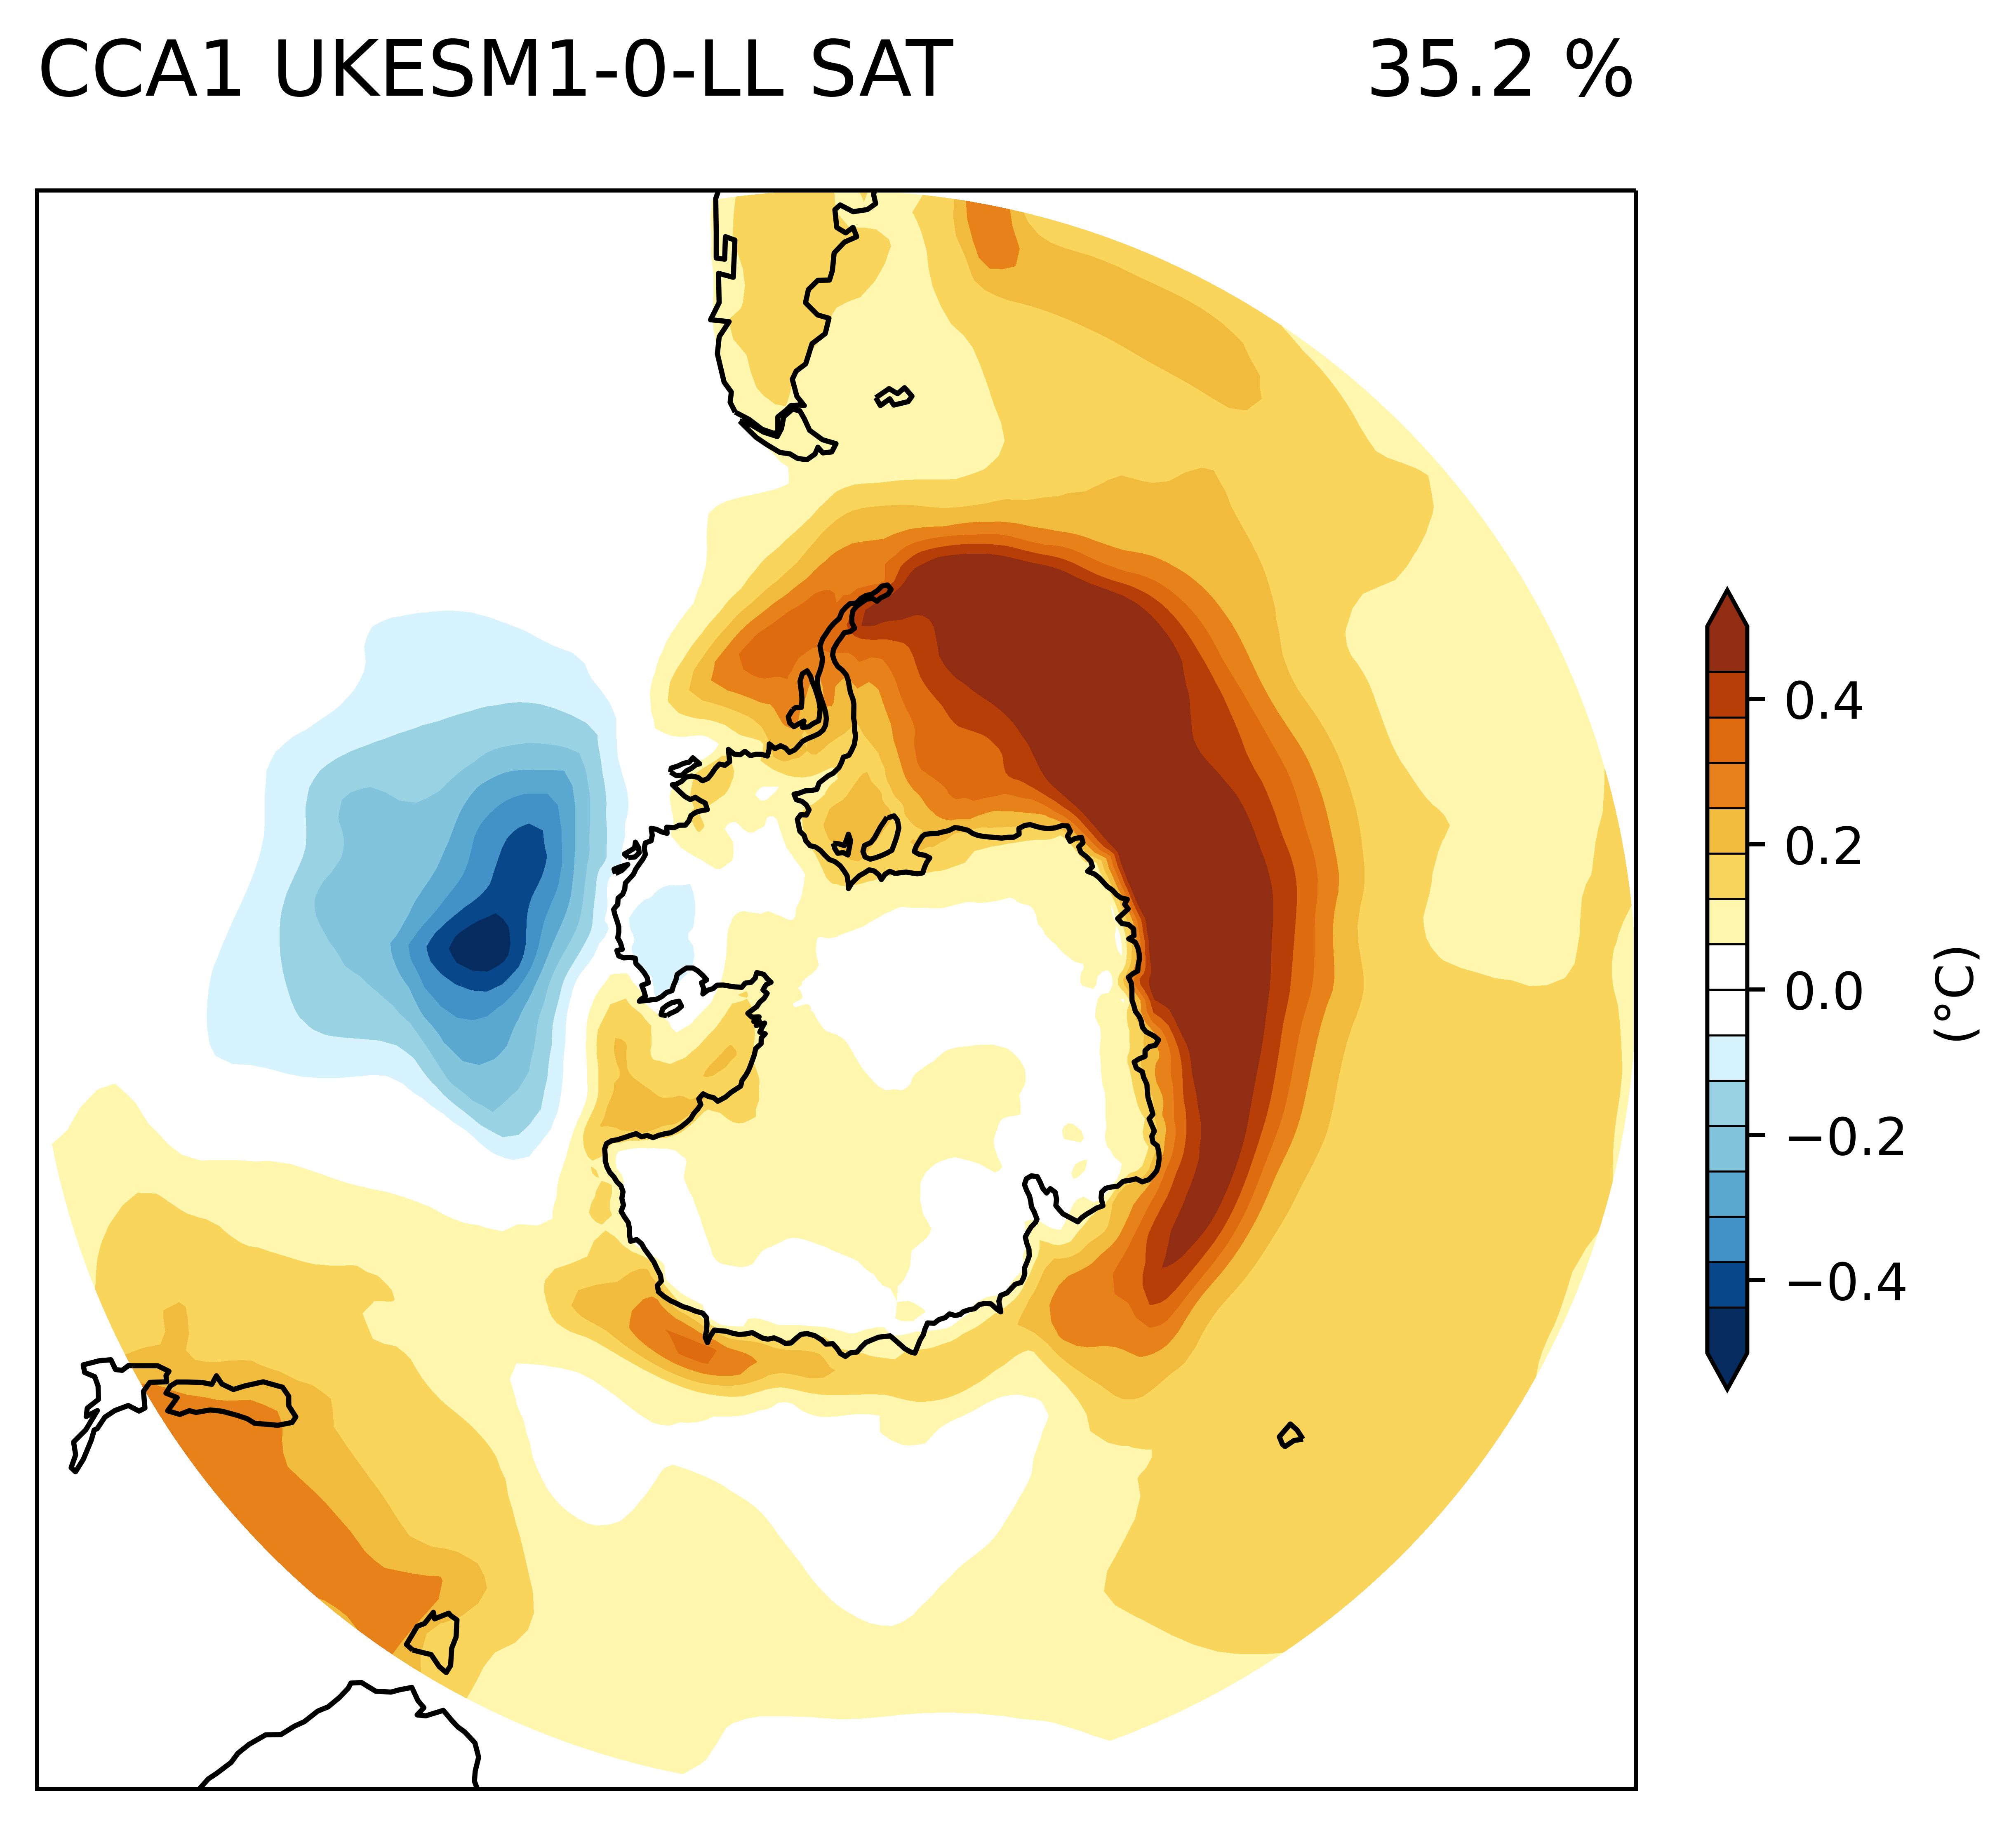

In [39]:
import cartopy.util as cutil
import numpy as np
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(8, 5), dpi=900, subplot_kw={"projection": ccrs.SouthPolarStereo(central_longitude=-65)})
#ax.set_extent([-180, 180, -80, 80], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
#ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
#ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='white', zorder=4)

# Add cyclic point to data to remove the white line over the 0 meridian
data, lon = cutil.add_cyclic_point(regSST1, coord=ds1['lon'])

# Color scheme
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

# Plot the data using the specified color scheme
cf = ax.contourf(lon, ds1['lat'], data, transform=ccrs.PlateCarree(),
                 cmap=cmap, levels=np.linspace(-0.5, 0.5, 17),
                 vmin=-0.5, vmax=0.5,
                 extend='both')

cax = plt.colorbar(cf, ticks=np.arange(-0.6 + 0.2, 0.6, 0.2), drawedges=True,
                   orientation='vertical', label=r"(°C)", pad=0.025,
                   shrink=0.5, aspect=20)

gvutil.set_titles_and_labels(ax,
                             lefttitle='CCA1 UKESM1-0-LL SAT ',
                             lefttitlefontsize=15,
                             righttitle=f'{var_sst1_round.values} %',
                             righttitlefontsize=15,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)
#plt.savefig("CCA.SST1.10p.pdf", format="pdf", bbox_inches='tight', dpi=900)
plt.savefig("CCA.1.SAT.10p.jpg", format="jpg", bbox_inches='tight', dpi=900)
plt.tight_layout()


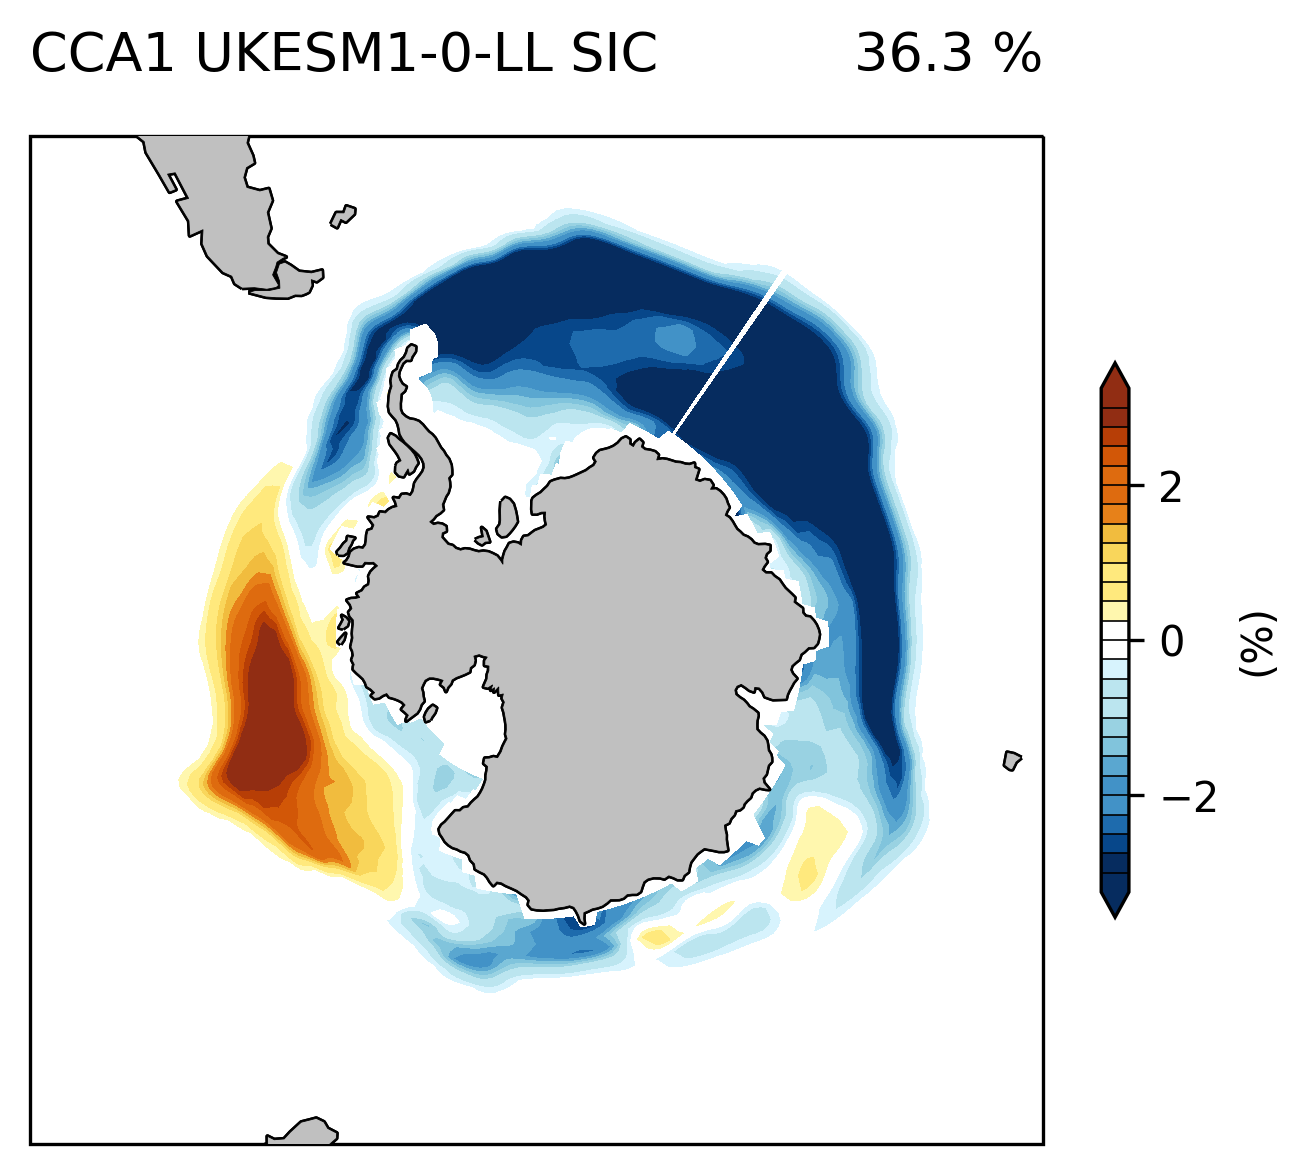

In [40]:
fig3, ax3= plt.subplots(figsize=(8, 4), dpi=300, subplot_kw={"projection":ccrs.SouthPolarStereo(central_longitude=-35),})
                                                  #NorthPolarStereo(central_longitude=-30.0,latitude=40, globe=None)})
#ax.set_extent([0, 360, 50, 90], crs=ccrs.PlateCarree())
ax3.set_extent([0, 360, -90, -48], crs=ccrs.PlateCarree())
ax3.coastlines(resolution='110m')
ax3.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax3.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax3.add_feature(cfeature.LAKES,
               edgecolor='black',
               linewidth=0.2,
               facecolor='white',
               zorder=4)
gvutil.add_lat_lon_ticklabels(ax3)
gvutil.add_major_minor_ticks(ax3, labelsize=20)
#gv.set_map_boundary(ax3, [-180, 180], [-90, -50], south_pad=1)



level_min=-3
level_max=3
stepsize=0.25
levels=np.arange(level_min-stepsize/1,level_max+stepsize/1+stepsize,stepsize)

#cmap = sns.color_palette("coolwarm", as_cmap=True)


#cmap = gvcmaps.BlueDarkRed18
#newcmp = gvcmaps.BlueDarkRed18
#cmap=sns.diverging_palette(660, 30, s=60, as_cmap=True)
#cmap='seismic'

newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

cf=ax3.contourf(ds2['lon'], ds2['lat'], regSIC1, transform=ccrs.PlateCarree(),
              cmap=cmap, levels=levels, 
              vmin=level_min-.05, vmax=level_max+.05,
              extend='both')

cax=plt.colorbar(cf, ticks=np.arange(level_min+1,level_max,2), drawedges=True, orientation='vertical',
                       label=r"(%)",pad=0.025,shrink=0.55,aspect=20,)

gvutil.set_titles_and_labels(ax3,
                             lefttitle='CCA1 UKESM1-0-LL SIC',
                             lefttitlefontsize=13,
                             righttitle=f'{var_sic1_round.values} %',
                             righttitlefontsize=13,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)
#plt.savefig("CCA.SIC1a.pdf",format="pdf", bbox_inches = 'tight',dpi=600)
plt.savefig("CCA.SIC1a.jpg",format="jpg", bbox_inches = 'tight',dpi=600)

ax3.coastlines()
plt.tight_layout()
plt.show()




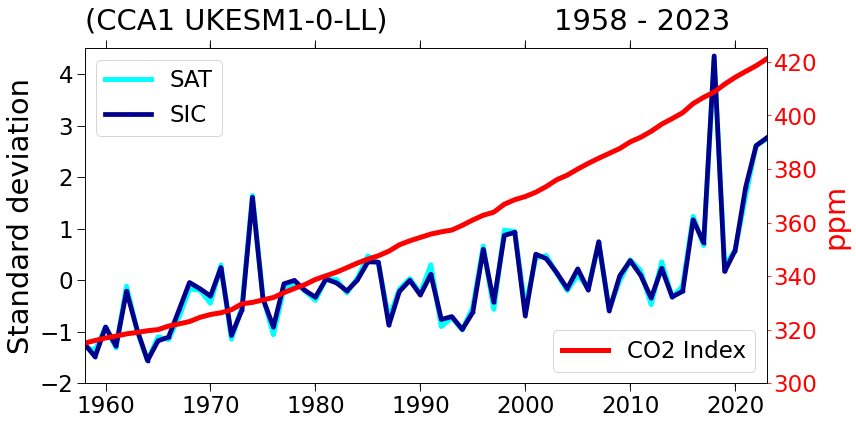

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load CO2 data from co2_annmean_mlo.csv
co2_data = pd.read_csv("co2_annmean_mlo_1958.csv")

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use geocat.viz.util convenience function to set axes tick values
gvutil.set_titles_and_labels(ax1,
                             lefttitle=f'(CCA1 UKESM1-0-LL)                  1958 - 2023',
                             lefttitlefontsize=29,
                             righttitle=f'',
                             righttitlefontsize=29,
                             xlabel="",
                             ylabel="Standard deviation",
                             labelfontsize=29)
gv.add_major_minor_ticks(ax1,
                         x_minor_per_major=1,
                         y_minor_per_major=1,
                         labelsize=23)

# Plot SST and SIC data
ax1.plot(ds1.time, PC1sst, color='aqua', linewidth=5, label='SAT')
ax1.plot(ds1.time, PC1sic, marker='o', markerfacecolor='blue', markersize=2.8, color='darkblue', linewidth=4.75, label='SIC')
ax1.legend(prop={"size": 23})
ax1.set_ylim(-2, 4.5)  # Adjust the limits as needed
# Set x-axis limits and tick positions
ax1.set_xlim(pd.Timestamp('1958-01-01'), pd.Timestamp('2023-01-01'))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=10))

# Create secondary y-axis for CO2 data
ax2 = ax1.twinx()
ax2.plot(ds1.time, co2_data['mean'], color='red', linewidth=5, label='CO2 Index')
ax2.set_ylabel('ppm', fontsize=29, color='red')
ax2.tick_params(axis='y', colors='red', labelsize=23)  # Set label font size
ax2.set_ylim(300, 425)  # Adjust the limits as needed
ax2.legend(prop={"size": 23}, loc='lower right')

# Adjust layout and display the plot

#plt.savefig("FCCA.PC1.pdf", format="pdf", bbox_inches='tight', dpi= 600)
plt.savefig("CCA.PC1.jpg", format="jpg", bbox_inches='tight', dpi= 600)
plt.tight_layout()
plt.show()

***Pair 2***

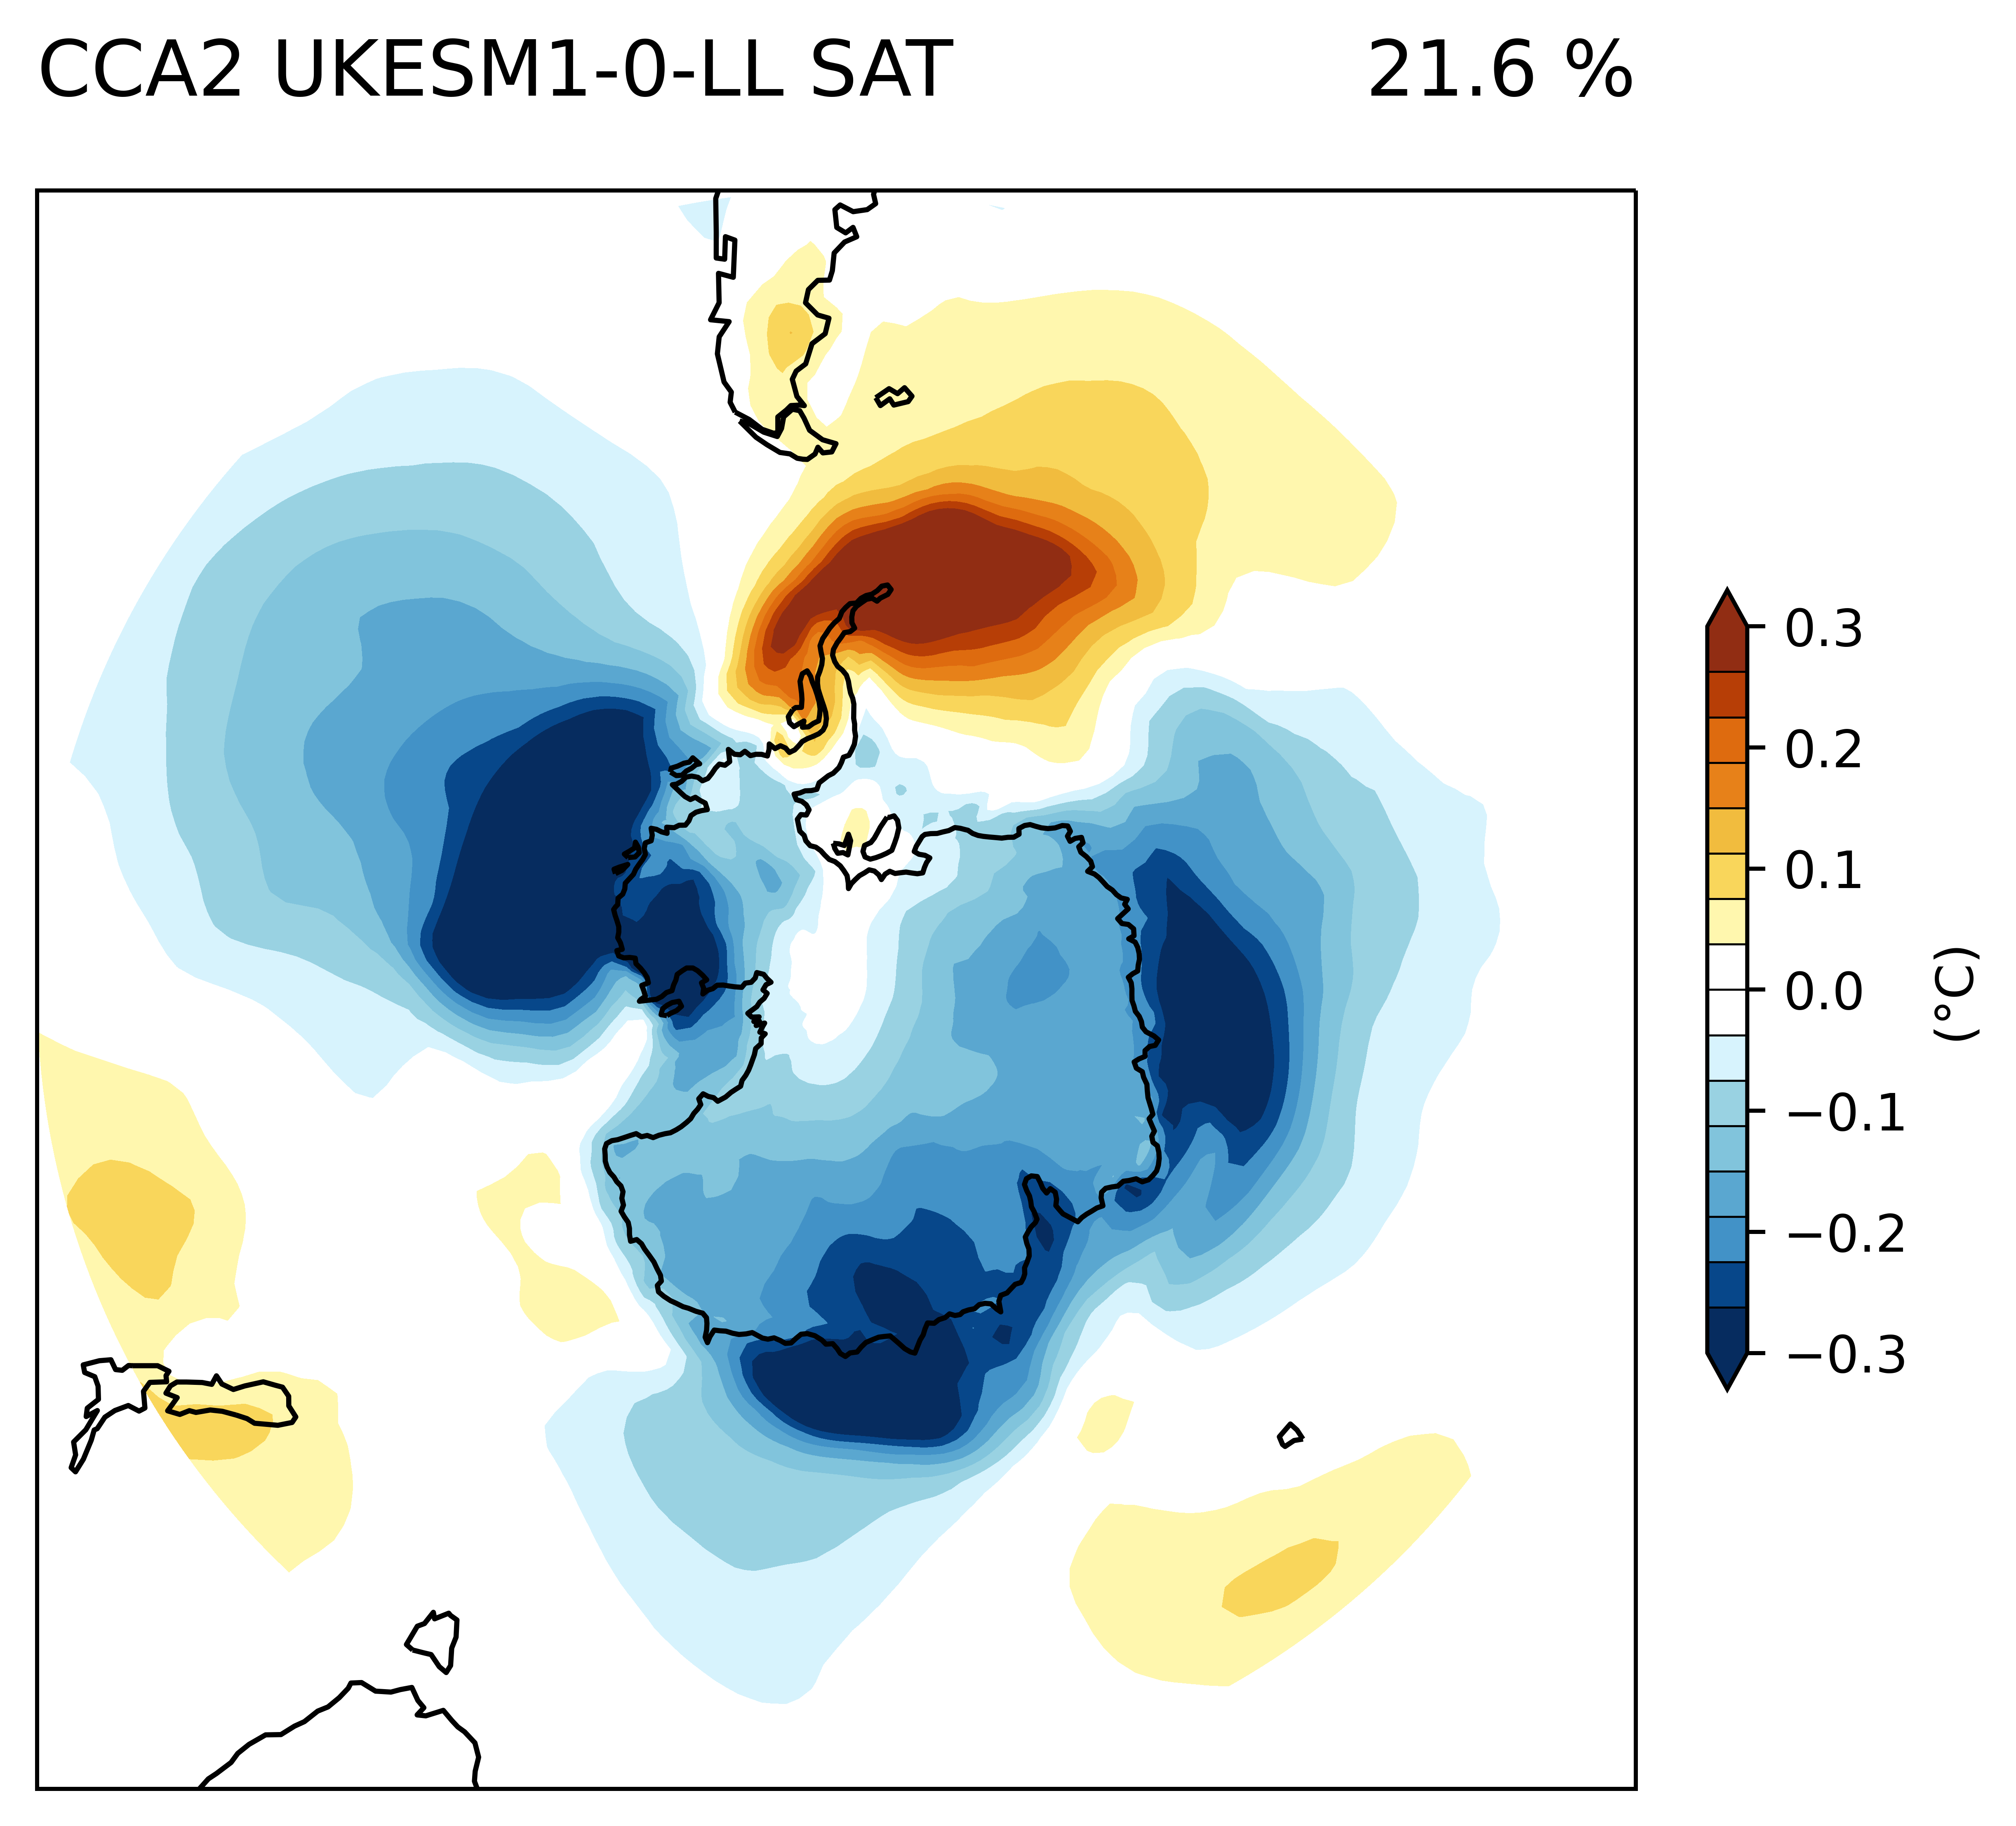

In [48]:
import cartopy.util as cutil
import numpy as np
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(8, 5), dpi=900, subplot_kw={"projection": ccrs.SouthPolarStereo(central_longitude=-65)})
#ax.set_extent([-180, 180, -80, 80], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
#ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
#ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='white', zorder=4)

# Add cyclic point to data to remove the white line over the 0 meridian
data, lon = cutil.add_cyclic_point(-regSST2, coord=ds1['lon'])

# Color scheme
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

# Plot the data using the specified color scheme
cf = ax.contourf(lon, ds1['lat'], data, transform=ccrs.PlateCarree(),
                 cmap=cmap, levels=np.linspace(-0.3, 0.3, 17),
                 vmin=-0.3, vmax=0.3,
                 extend='both')

cax = plt.colorbar(cf, ticks=np.arange(-0.4 + 0.1, 0.4, 0.1), drawedges=True,
                   orientation='vertical', label=r"(°C)", pad=0.025,
                   shrink=0.5, aspect=20)

gvutil.set_titles_and_labels(ax,
                             lefttitle='CCA2 UKESM1-0-LL SAT ',
                             lefttitlefontsize=15,
                             righttitle=f'{var_sst2_round.values} %',
                             righttitlefontsize=15,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)
#plt.savefig("CCA.SST1.10p.pdf", format="pdf", bbox_inches='tight', dpi=900)
plt.savefig("CCA.SST2.10p.jpg", format="jpg", bbox_inches='tight', dpi=900)
plt.tight_layout()


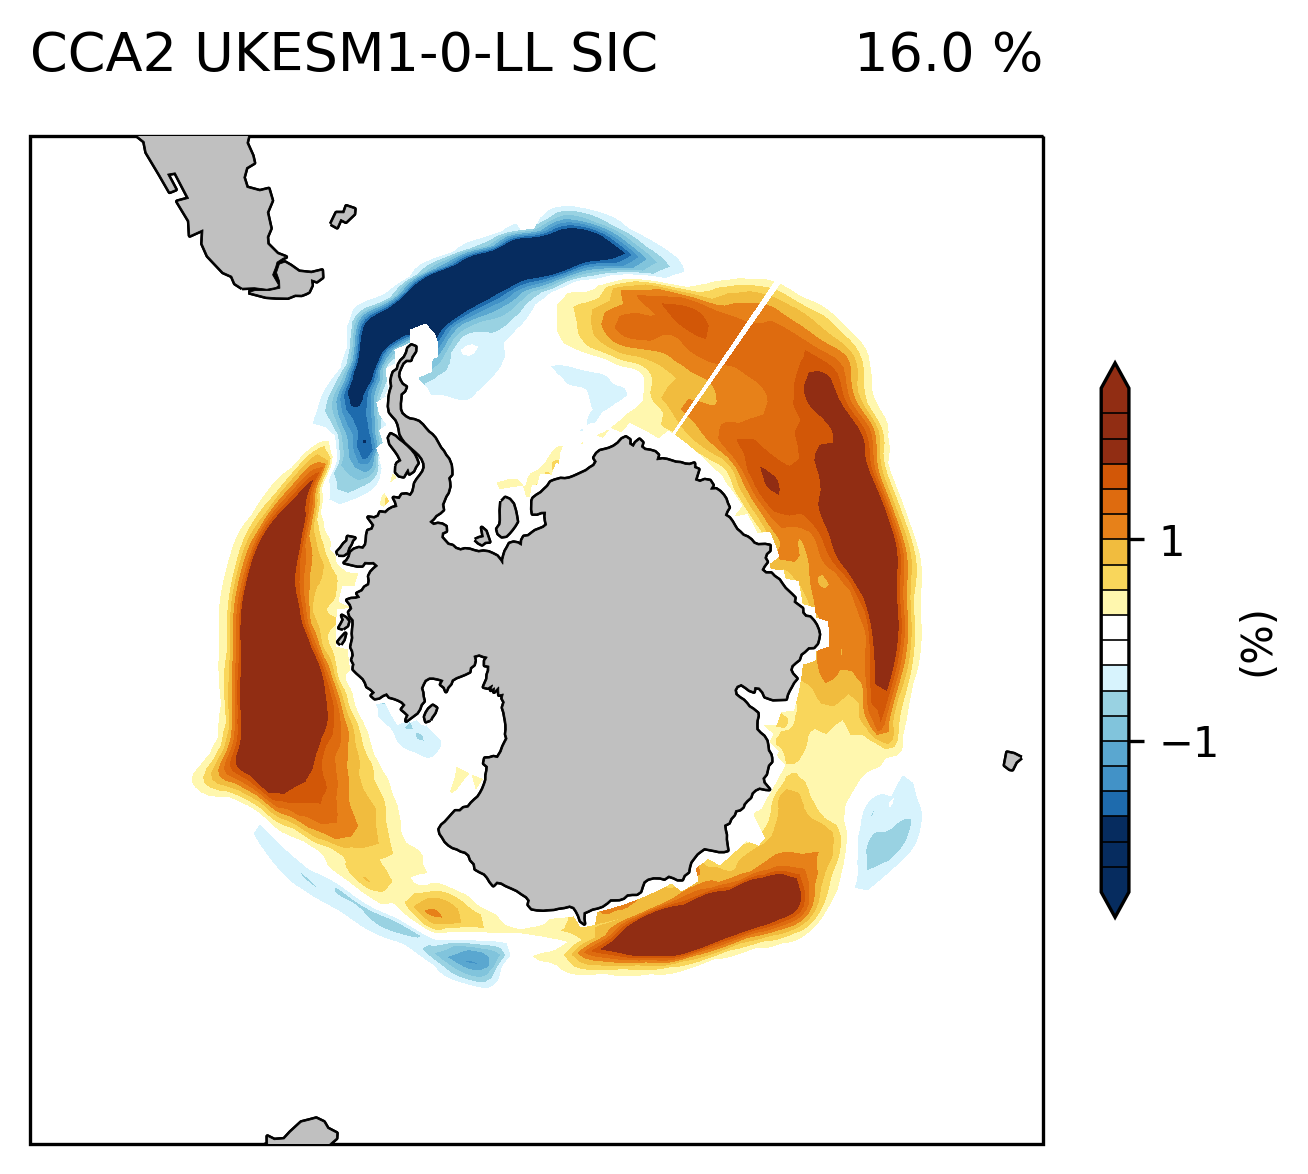

In [49]:
fig3, ax3= plt.subplots(figsize=(8, 4), dpi=300, subplot_kw={"projection":ccrs.SouthPolarStereo(central_longitude=-35),})
                                                  #NorthPolarStereo(central_longitude=-30.0,latitude=40, globe=None)})
#ax.set_extent([0, 360, 50, 90], crs=ccrs.PlateCarree())
ax3.set_extent([0, 360, -90, -48], crs=ccrs.PlateCarree())
ax3.coastlines(resolution='110m')
ax3.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax3.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax3.add_feature(cfeature.LAKES,
               edgecolor='black',
               linewidth=0.2,
               facecolor='white',
               zorder=4)
gvutil.add_lat_lon_ticklabels(ax3)
gvutil.add_major_minor_ticks(ax3, labelsize=20)
#gv.set_map_boundary(ax3, [-180, 180], [-90, -50], south_pad=1)



level_min=-2
level_max=2
stepsize=0.25
levels=np.arange(level_min-stepsize/0.5,level_max+stepsize/0.5+stepsize,stepsize)

#cmap = sns.color_palette("coolwarm", as_cmap=True)


#cmap = gvcmaps.BlueDarkRed18
#newcmp = gvcmaps.BlueDarkRed18
#cmap=sns.diverging_palette(660, 30, s=60, as_cmap=True)
#cmap='seismic'

newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

cf=ax3.contourf(ds2['lon'], ds2['lat'], -regSIC2, transform=ccrs.PlateCarree(),
              cmap=cmap, levels=levels, 
              vmin=level_min-.05, vmax=level_max+.05,
              extend='both')

cax=plt.colorbar(cf, ticks=np.arange(level_min+1,level_max,2), drawedges=True, orientation='vertical',
                       label=r"(%)",pad=0.025,shrink=0.55,aspect=20,)

gvutil.set_titles_and_labels(ax3,
                             lefttitle='CCA2 UKESM1-0-LL SIC',
                             lefttitlefontsize=13,
                             righttitle=f'{var_sic2_round.values} %',
                             righttitlefontsize=13,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)
#plt.savefig("CCA.SIC1a.pdf",format="pdf", bbox_inches = 'tight',dpi=600)
plt.savefig("CCA.SIC2a.jpg",format="jpg", bbox_inches = 'tight',dpi=600)

ax3.coastlines()
plt.tight_layout()
plt.show()




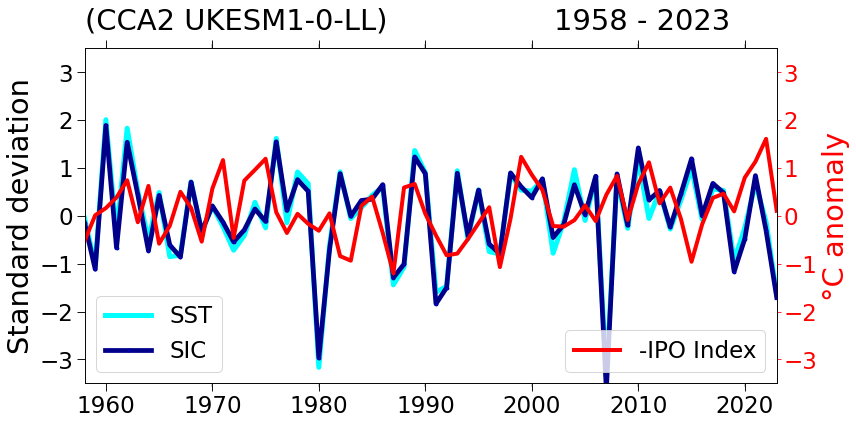

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Correct way to load data from an Excel file
IPO_data = pd.read_excel("IPO_Index_Unfilred_Tripole_1950_2023 (1).xlsx")

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use geocat.viz.util convenience function to set axes tick values
gvutil.set_titles_and_labels(ax1,
                             lefttitle=f'(CCA2 UKESM1-0-LL)                  1958 - 2023',
                             lefttitlefontsize=29,
                             righttitle=f'',
                             righttitlefontsize=29,
                             xlabel="",
                             ylabel="Standard deviation",
                             labelfontsize=29)
gv.add_major_minor_ticks(ax1,
                         x_minor_per_major=1,
                         y_minor_per_major=1,
                         labelsize=23)

# Plot SST and SIC data
ax1.plot(ds1.time, -PC2sst, color='aqua', linewidth=5, label='SST')
ax1.plot(ds1.time, -PC2sic, marker='o', markerfacecolor='blue', markersize=2.8, color='darkblue', linewidth=4.75, label='SIC')
ax1.set_ylim(-3.5, 3.5)  # Adjust the limits as needed
ax1.legend(prop={"size": 23})
ax1.legend(prop={"size": 23}, loc='lower left')
# Set x-axis limits and tick positions
ax1.set_xlim(pd.Timestamp('1958-01-01'), pd.Timestamp('2023-01-01'))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=10))

# Create secondary y-axis for AMO data
ax2 = ax1.twinx()
ax2.plot(ds1.time, -IPO_data['Values'], color='red', linewidth=4, label='-IPO Index')
ax2.set_ylabel('°C anomaly', fontsize=29, color='red')
ax2.tick_params(axis='y', colors='red', labelsize=23)  # Set label font size
ax2.set_ylim(-3.5, 3.5)  # Adjust the limits as needed
ax2.legend(prop={"size": 23}, loc='lower right')

# Adjust layout and display the plot

#plt.savefig("CCA.P2.pdf",format="pdf", bbox_inches = 'tight', dpi= 600)
plt.savefig("CCA.PC2.jpg",format="jpg", bbox_inches = 'tight', dpi= 600)
plt.tight_layout()
plt.show()

***Pair 3***

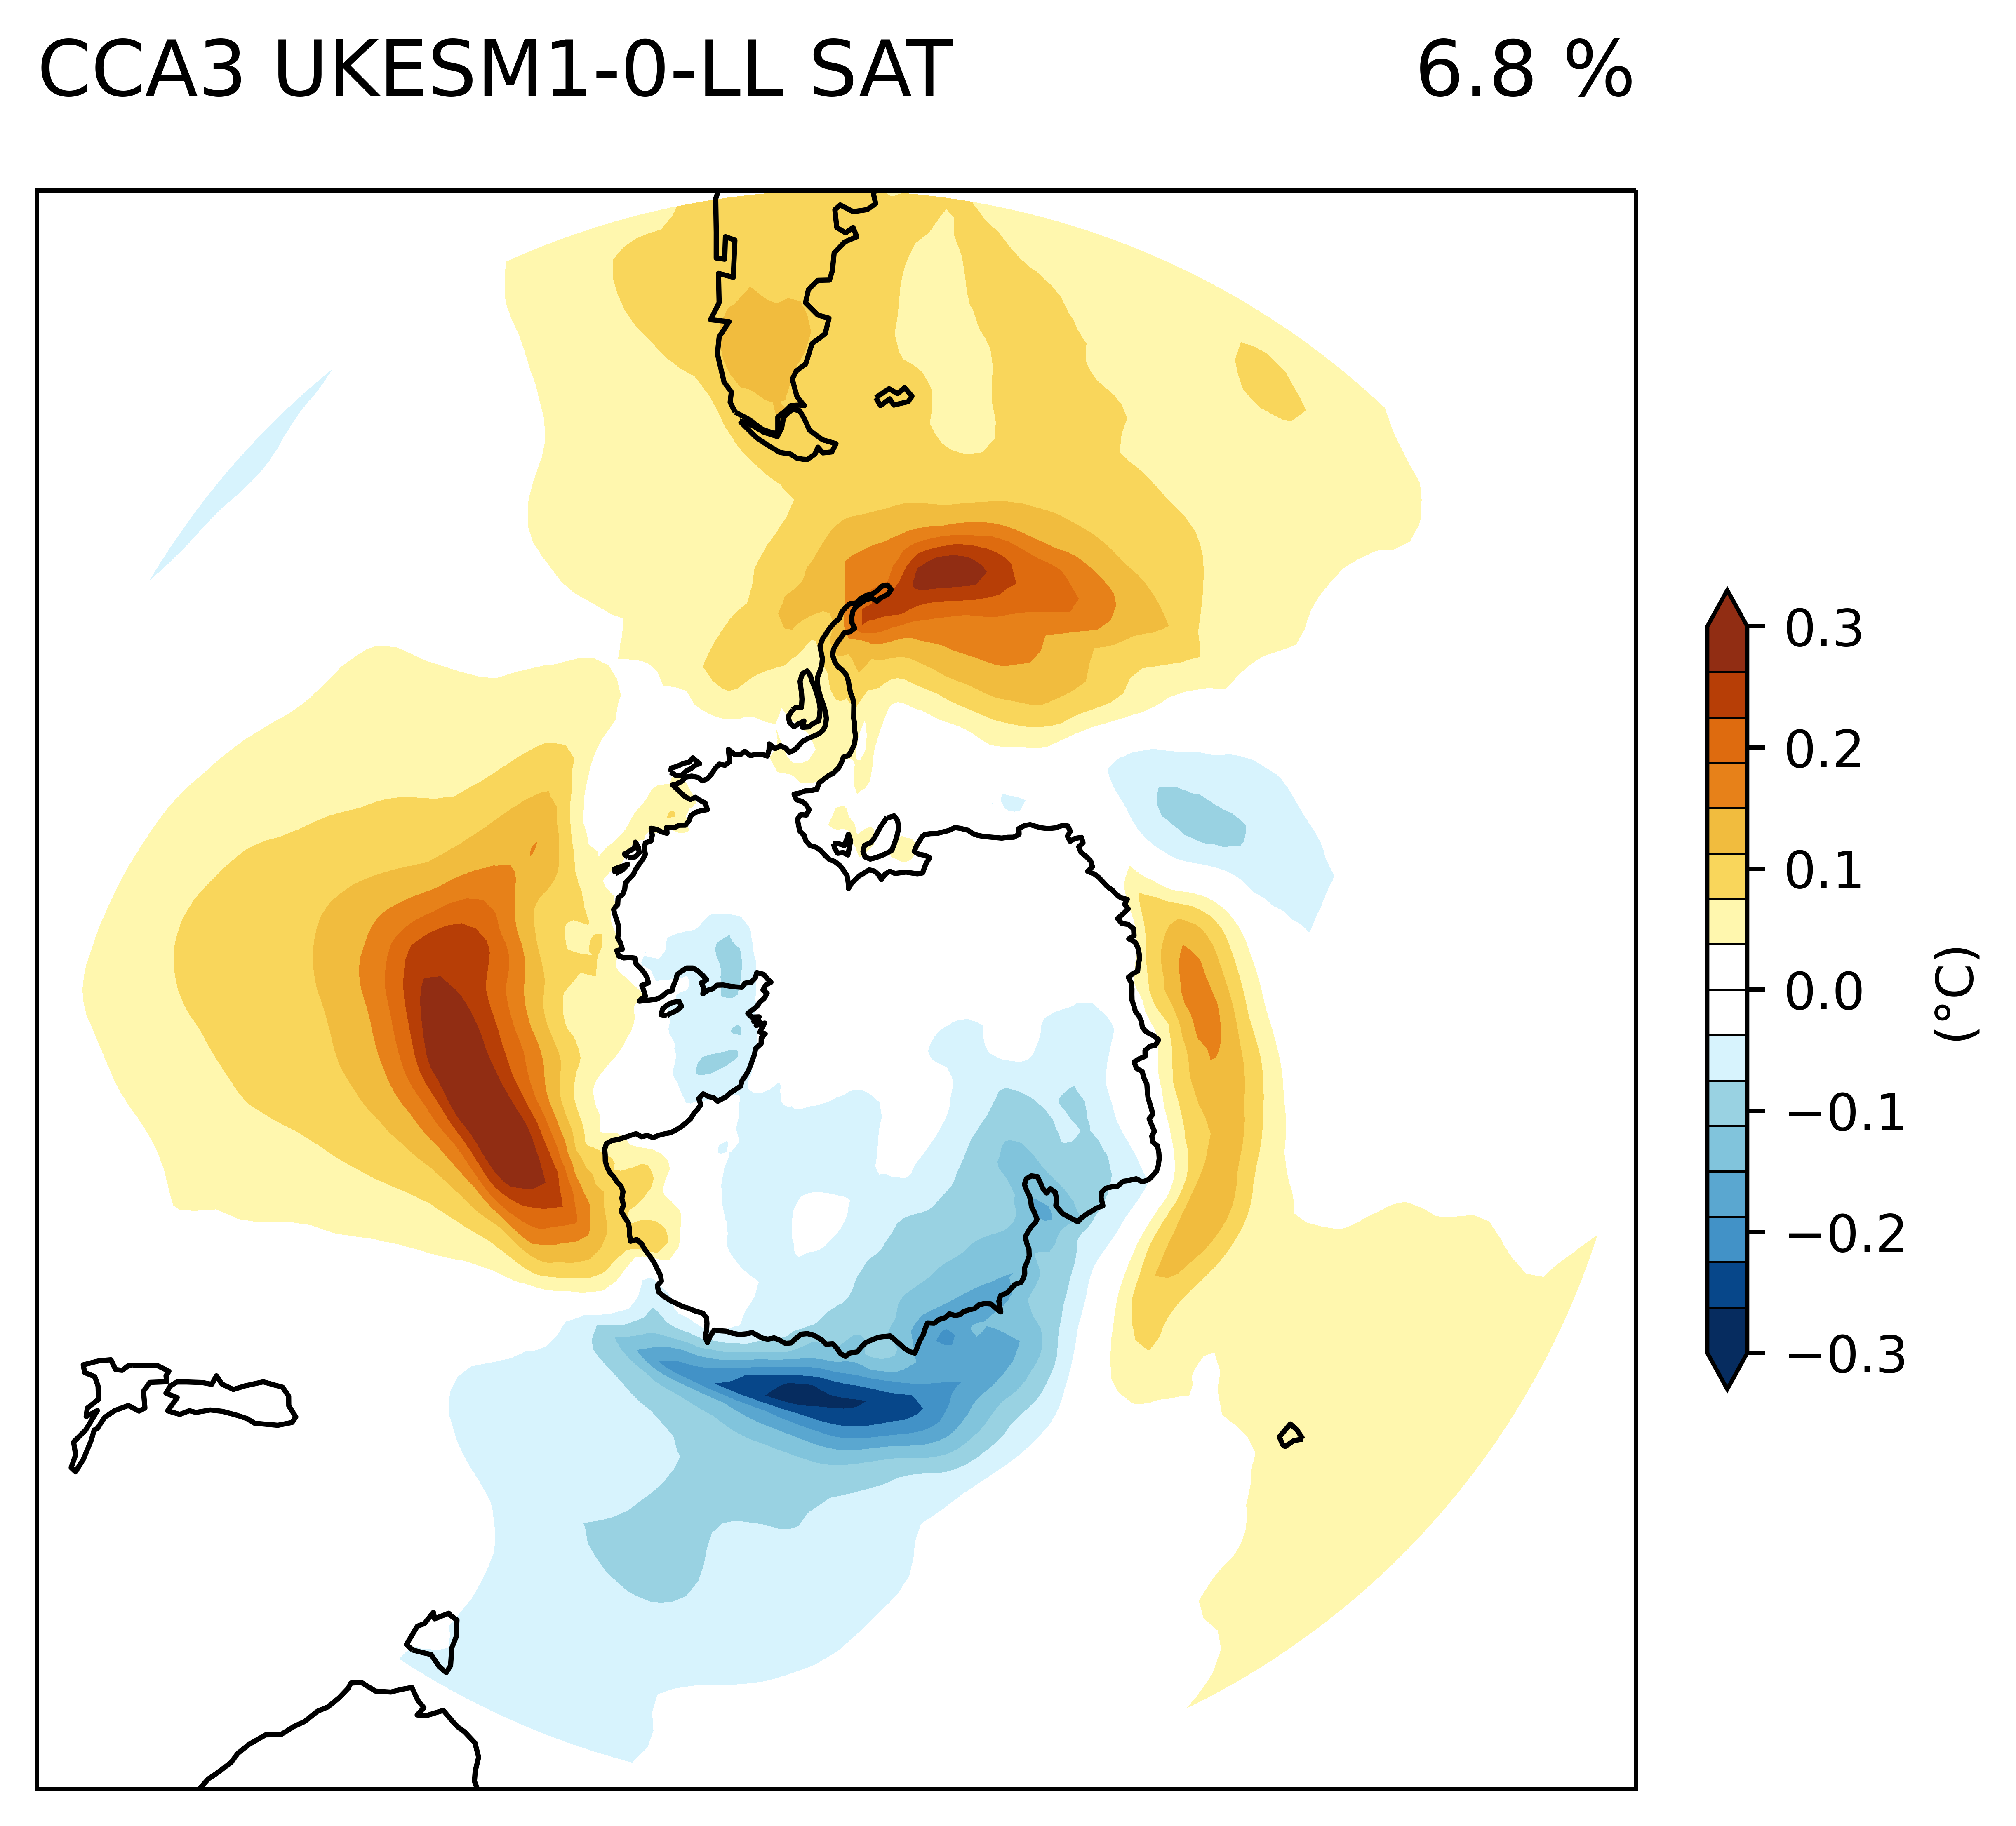

In [46]:
import cartopy.util as cutil
import numpy as np
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(8, 5), dpi=900, subplot_kw={"projection": ccrs.SouthPolarStereo(central_longitude=-65)})
#ax.set_extent([-180, 180, -80, 80], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
#ax.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
#ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.2, facecolor='white', zorder=4)

# Add cyclic point to data to remove the white line over the 0 meridian
data, lon = cutil.add_cyclic_point(regSST3, coord=ds1['lon'])

# Color scheme
newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

# Plot the data using the specified color scheme
cf = ax.contourf(lon, ds1['lat'], data, transform=ccrs.PlateCarree(),
                 cmap=cmap, levels=np.linspace(-0.3, 0.3, 17),
                 vmin=-0.3, vmax=0.3,
                 extend='both')

cax = plt.colorbar(cf, ticks=np.arange(-0.4 + 0.1, 0.4, 0.1), drawedges=True,
                   orientation='vertical', label=r"(°C)", pad=0.025,
                   shrink=0.5, aspect=20)

gvutil.set_titles_and_labels(ax,
                             lefttitle='CCA3 UKESM1-0-LL SAT ',
                             lefttitlefontsize=15,
                             righttitle=f'{var_sst3_round.values} %',
                             righttitlefontsize=15,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)
#plt.savefig("CCA.SST1.10p.pdf", format="pdf", bbox_inches='tight', dpi=900)
plt.savefig("CCA.SST3.10p.jpg", format="jpg", bbox_inches='tight', dpi=900)
plt.tight_layout()


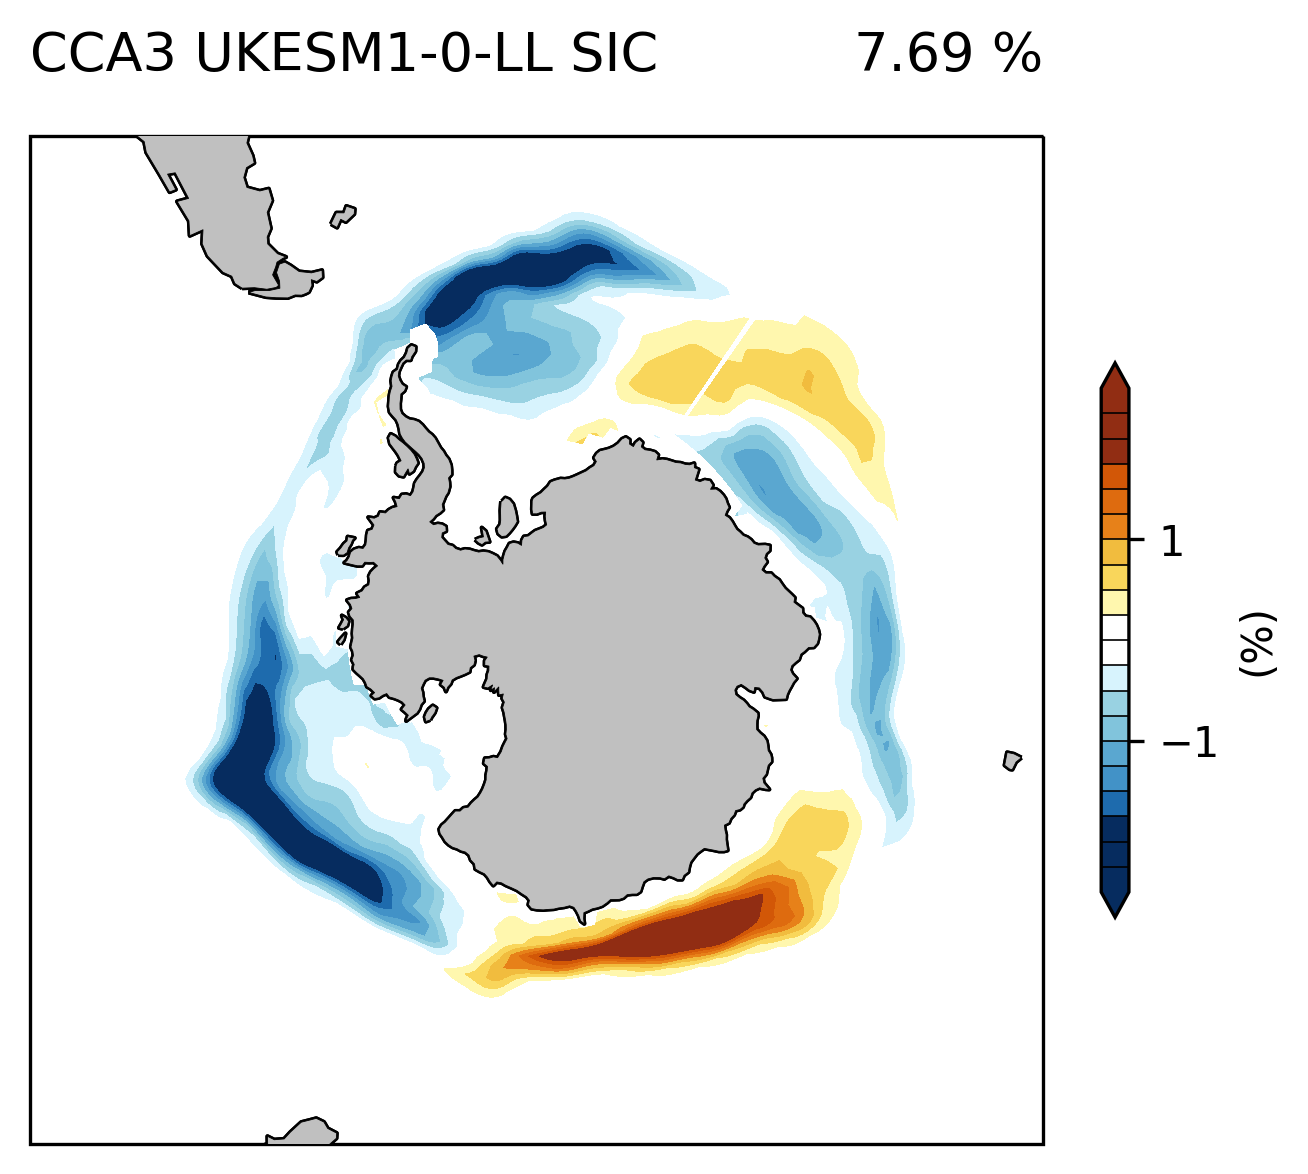

In [47]:
fig3, ax3= plt.subplots(figsize=(8, 4), dpi=300, subplot_kw={"projection":ccrs.SouthPolarStereo(central_longitude=-35),})
                                                  #NorthPolarStereo(central_longitude=-30.0,latitude=40, globe=None)})
#ax.set_extent([0, 360, 50, 90], crs=ccrs.PlateCarree())
ax3.set_extent([0, 360, -90, -48], crs=ccrs.PlateCarree())
ax3.coastlines(resolution='110m')
ax3.add_feature(cfeature.LAND, facecolor='silver', zorder=3)
ax3.add_feature(cfeature.COASTLINE, linewidth=0.2, zorder=3)
ax3.add_feature(cfeature.LAKES,
               edgecolor='black',
               linewidth=0.2,
               facecolor='white',
               zorder=4)
gvutil.add_lat_lon_ticklabels(ax3)
gvutil.add_major_minor_ticks(ax3, labelsize=20)
#gv.set_map_boundary(ax3, [-180, 180], [-90, -50], south_pad=1)



level_min=-2
level_max=2
stepsize=0.25
levels=np.arange(level_min-stepsize/0.5,level_max+stepsize/0.5+stepsize,stepsize)

#cmap = sns.color_palette("coolwarm", as_cmap=True)


#cmap = gvcmaps.BlueDarkRed18
#newcmp = gvcmaps.BlueDarkRed18
#cmap=sns.diverging_palette(660, 30, s=60, as_cmap=True)
#cmap='seismic'

newcmp = gvcmaps.BlueYellowRed
index = [5, 20, 35, 50, 65, 85, 95, 110, 125, 0, 0, 135, 150, 165, 180, 200, 210, 220, 235, 250]
color_list = [newcmp[i].colors for i in index]
color_list[9] = [1., 1., 1.]
color_list[10] = [1., 1., 1.]
cmap = mcolors.ListedColormap(color_list)

cf=ax3.contourf(ds2['lon'], ds2['lat'], regSIC3, transform=ccrs.PlateCarree(),
              cmap=cmap, levels=levels, 
              vmin=level_min-.05, vmax=level_max+.05,
              extend='both')

cax=plt.colorbar(cf, ticks=np.arange(level_min+1,level_max,2), drawedges=True, orientation='vertical',
                       label=r"(%)",pad=0.025,shrink=0.55,aspect=20,)

gvutil.set_titles_and_labels(ax3,
                             lefttitle='CCA3 UKESM1-0-LL SIC',
                             lefttitlefontsize=13,
                             righttitle=f'{var_sic3_round.values} %',
                             righttitlefontsize=13,
                             xlabel="Year",
                             ylabel="sdaasd",
                             labelfontsize=21)
#plt.savefig("CCA.SIC1a.pdf",format="pdf", bbox_inches = 'tight',dpi=600)
plt.savefig("CCA.SIC3a.jpg",format="jpg", bbox_inches = 'tight',dpi=600)

ax3.coastlines()
plt.tight_layout()
plt.show()

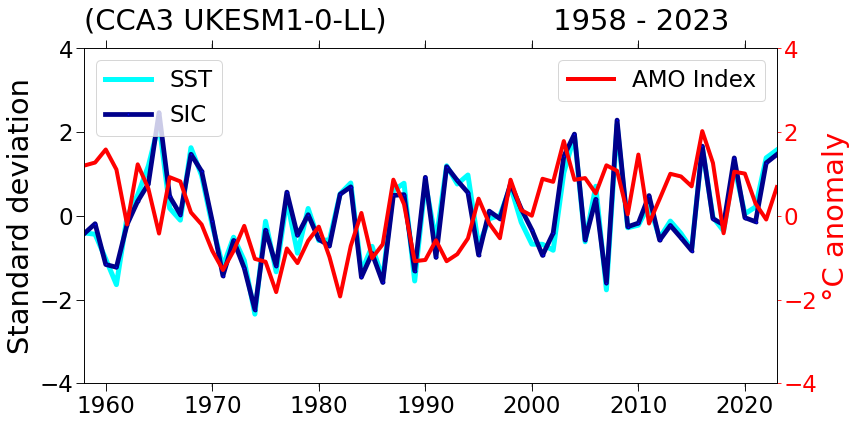

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Correct way to load data from an Excel file
AMO_data = pd.read_excel("AMO_Index_PC2_SST_1958_2023.xlsx")

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use geocat.viz.util convenience function to set axes tick values
gvutil.set_titles_and_labels(ax1,
                             lefttitle=f'(CCA3 UKESM1-0-LL)                  1958 - 2023',
                             lefttitlefontsize=29,
                             righttitle=f'',
                             righttitlefontsize=29,
                             xlabel="",
                             ylabel="Standard deviation",
                             labelfontsize=29)
gv.add_major_minor_ticks(ax1,
                         x_minor_per_major=1,
                         y_minor_per_major=1,
                         labelsize=23)

# Plot SST and SIC data
ax1.plot(ds1.time, PC3sst, color='aqua', linewidth=5, label='SST')
ax1.plot(ds1.time, PC3sic, marker='o', markerfacecolor='blue', markersize=2.8, color='darkblue', linewidth=4.75, label='SIC')
ax1.set_ylim(-4, 4)  # Adjust the limits as needed
ax1.legend(prop={"size": 23})
ax1.legend(prop={"size": 23}, loc='lower left')
# Set x-axis limits and tick positions
ax1.set_xlim(pd.Timestamp('1958-01-01'), pd.Timestamp('2023-01-01'))
ax1.xaxis.set_major_locator(mdates.YearLocator(base=10))
ax1.legend(prop={"size": 23}, loc='upper left')
# Create secondary y-axis for AMO data
ax2 = ax1.twinx()
ax2.plot(ds1.time, AMO_data['Values'], color='red', linewidth=4, label='AMO Index')
ax2.set_ylabel('°C anomaly', fontsize=29, color='red')
ax2.tick_params(axis='y', colors='red', labelsize=23)  # Set label font size
ax2.set_ylim(-4, 4)  # Adjust the limits as needed
ax2.legend(prop={"size": 23}, loc='upper right')

# Adjust layout and display the plot

#plt.savefig("CCA.P2.pdf",format="pdf", bbox_inches = 'tight', dpi= 600)
plt.savefig("CCA.PC3.jpg",format="jpg", bbox_inches = 'tight', dpi= 600)
plt.tight_layout()
plt.show()